In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sikit-Learn Libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
# Load dataset from seaborn
df = sns.load_dataset('penguins')
print(f" The Penguins dataset has {df.shape[0]} rows {df.shape[1]} columns")
df.head()

 The Penguins dataset has 344 rows 7 columns


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


# Dataset Overview

The Penguins dataset contains 344 observations and 7 columns, where each row represents an individual penguin.

The goal in most analyses is to predict the penguin species based on physical measurements and categorical attributes.

This is a **small**, **clean**, **real-world–like dataset**, suitable for demonstrating classification workflows, especially with tree-based models such as Random Forest.

---

### **Column Descriptions**

1. `species`: Target variable. The penguin species (e.g., Adelie, Chinstrap, Gentoo). This is a multiclass categorical label.

2. `island`: Categorical feature indicating the island where the penguin was observed. Acts as a geographic/contextual variable.

3. `bill_length_mm`: Numerical feature measuring the length of the penguin’s bill (in millimeters). Often highly discriminative between species.

4. `bill_depth_mm`: Numerical feature measuring the depth (thickness) of the bill (in millimeters). Complements bill length for species separation.

5. `flipper_length_mm`: Numerical feature representing flipper length (in millimeters). Strongly correlated with body size and species.

6. `body_mass_g`: Numerical feature indicating body mass (in grams). Useful but can overlap across species.

7. `sex`: Categorical feature indicating biological sex (Male/Female). May help slightly but should not be overweighted.


In [3]:
# Check data types and structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


The dataset consists of 344 rows and 7 columns.

**Data Types Breakdown**

- Numerical features (float64): 4
  - bill_length_mm
  - bill_depth_mm
  - flipper_length_mm
  - body_mass_g

- Categorical features (object): 3
  - species (target variable)
  - island
  - sex

This mix of numerical and categorical variables aligns well with tree-based models such as Random Forest.

<br>

**Not all columns are complete:**

- **Numerical columns:** Each of the four measurement variables has 342 non-null values, meaning 2 missing entries per column.

- **Categorical column (sex):** Contains 333 non-null values, indicating 11 missing entries, which is non-trivial relative to dataset size.

- **Target (species) and island:** No missing values — this is critical, as missing labels would invalidate supervised learning.

In [4]:
df.isna().sum()

,0
species,0
island,0
bill_length_mm,2
bill_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,11



- The target variable (species) has no missing values, which means all rows are usable for supervised learning.
- Missing values in numerical features are minimal (2 out of 344, <1%).
- The sex column has the highest missingness (11 values, ~3.2%), which is noticeable but still manageable.
- Missing values are sparse and limited to a small subset of rows, not systematic across the dataset.

In [5]:
# Class Balance/Imbalance
df['species'].value_counts()

,count
species,
Adelie,152
Gentoo,124
Chinstrap,68


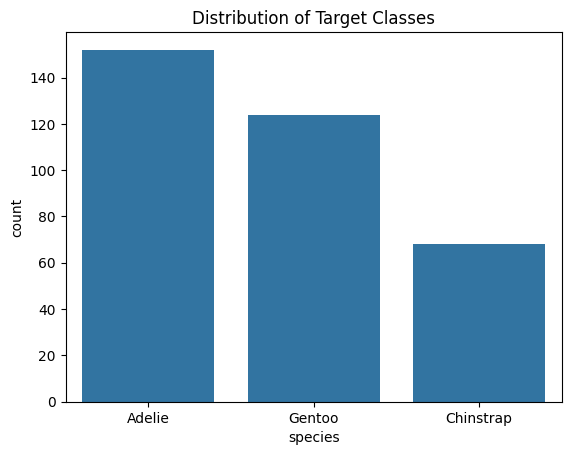

In [6]:
# Visualizing Imbalance
sns.countplot(data=df, x='species', order=df['species'].value_counts().index)
plt.title("Distribution of Target Classes")
plt.show()

### **Target Variable Distribution (Class Balance)**

The target variable `species` contains three classes with the following counts:

- Adelie: 152 samples
- Gentoo: 124 samples
- Chinstrap: 68 samples

The accompanying count plot visually confirms this distribution, showing a clear majority class (Adelie) and a smaller minority class (Chinstrap).

- The dataset is not perfectly balanced, but it is not severely imbalanced either.
- The minority class (Chinstrap) represents ~20% of the dataset, which is sufficient for training and evaluation.

In [7]:
# Exploring numerical feature
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


### **Numerical Feature Summary Statistics**

- All numerical features exhibit wide and realistic ranges, consistent with biological measurements.
- The mean and median values are relatively close for most features, suggesting no extreme skewness.
- Standard deviations indicate substantial variability, which is beneficial for classification.
- No immediate signs of invalid or impossible values are present.

In [8]:
df.columns

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'],
      dtype='object')

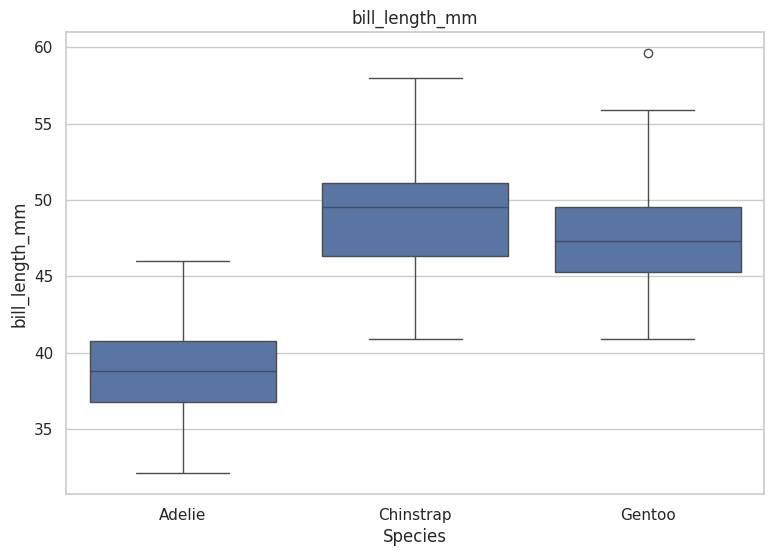

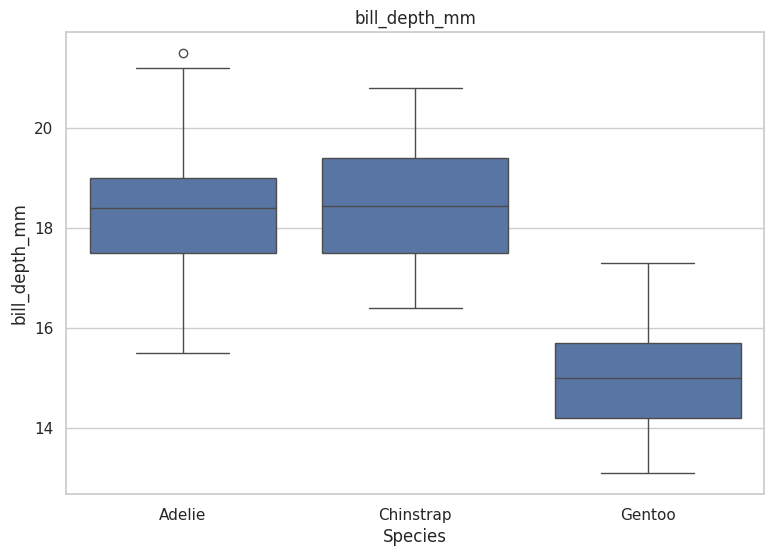

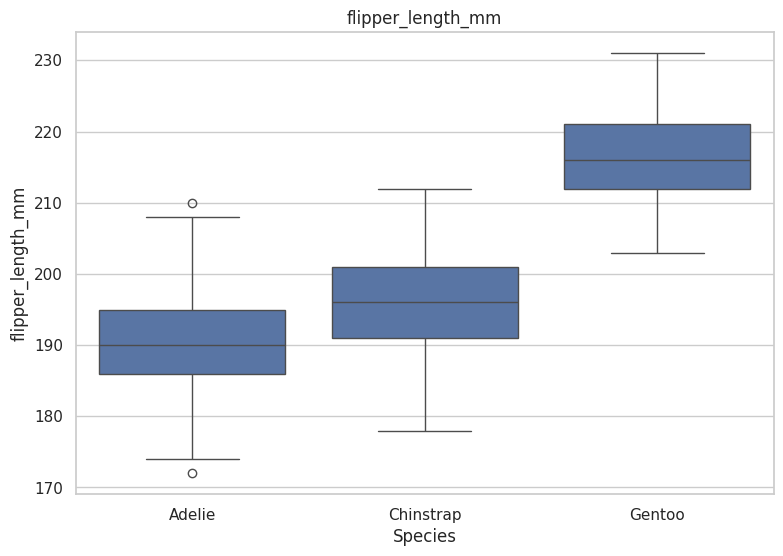

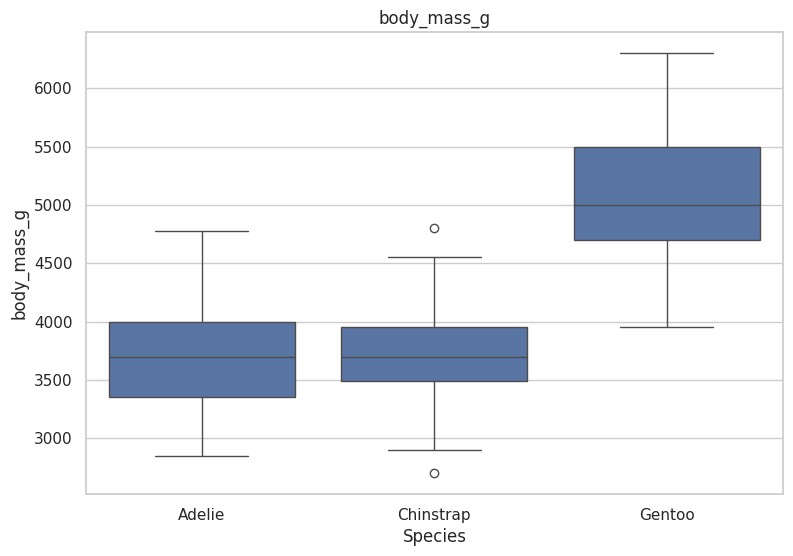

In [9]:
# Boxplot for understanding the separation in dataset
sns.set(style="whitegrid")

for col in df.columns[2:6]:
    plt.figure(figsize=(9, 6))
    sns.boxplot(x='species', y=col, data=df)
    plt.title(col)
    plt.xlabel('Species')
    plt.ylabel(col)
    plt.show()

## **Feature-wise Separation Using Boxplots**

Boxplots reveal that Gentoo penguins are clearly distinguished by higher body mass and flipper length but lower bill depth. Adelie and Chinstrap overlap more, though bill length provides strong separation. These distinct, biologically plausible variations across all features ensure high model importance and effective class discrimination.

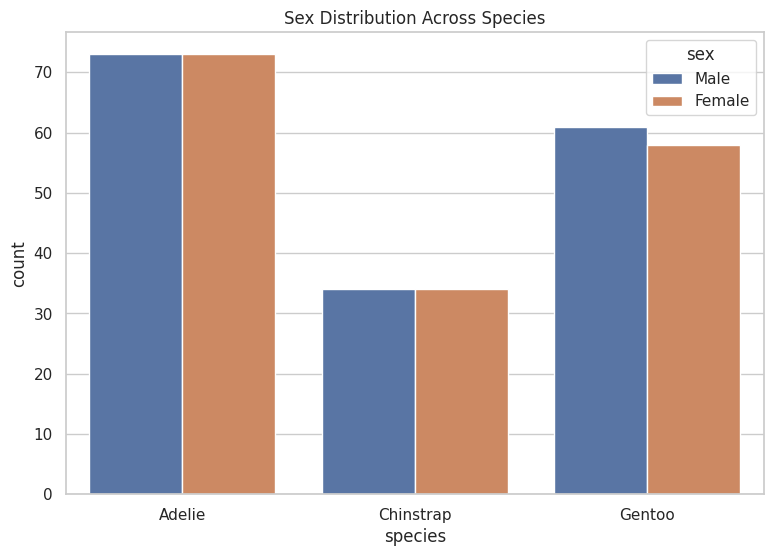

In [10]:
# Relationship between sex and species
plt.figure(figsize=(9, 6))
sns.countplot(
    data=df,
    x='species',
    hue='sex'
)
plt.title("Sex Distribution Across Species")
plt.show()

## **Relationship Between Sex and Species**

The count plot indicates balanced sex ratios across all three species, showing no significant correlation between sex and species. Consequently, sex is a weak standalone predictor compared to physical measurements. While useful for marginal gains in ensemble models, it serves as secondary context rather than a primary classification driver.

# **Final EDA Summary**

- The dataset contains 344 observations with a multiclass target (species) and a mix of numerical and categorical features.
- The target classes are mildly imbalanced, with no class being rare enough to require resampling.
- Missing values are low (<4%) and limited to feature columns; the target has no missing values.
- Imputation is preferred over row deletion to avoid unnecessary information loss in a small dataset.
- Numerical features show clear and biologically plausible separation across species, particularly:
  - flipper_length_mm
  - bill_length_mm
  - body_mass_g
- No extreme or invalid outliers were identified; observed extremes reflect genuine biological variation.
- The sex feature shows a balanced distribution across species and is expected to be a weak but valid supporting predictor.
- Based on feature behavior and class separability, a tree-based model (Random Forest) is well-suited for this task.
- Preprocessing decisions are finalized:
  - Median imputation for numerical features
  - Mode imputation + one-hot encoding for categorical features
  - Stratified train–test split
  - No feature scaling

# **Random Forest Model building**

In [11]:
# Spliting dataset in X (input) and y (output/target)
X = df.drop(columns='species')
y = df['species']

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
# Separateing feature types
numeric_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

categorical_features = ['island', 'sex']

In [13]:
# Building the preprocessing pipeline

# Numerical pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining them
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [14]:
# Building and adding the model to the pipeline

# Baseline Random Forest
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1) # n_jobs = -1 → uses all available cores

# Full pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [15]:
# Training the model
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



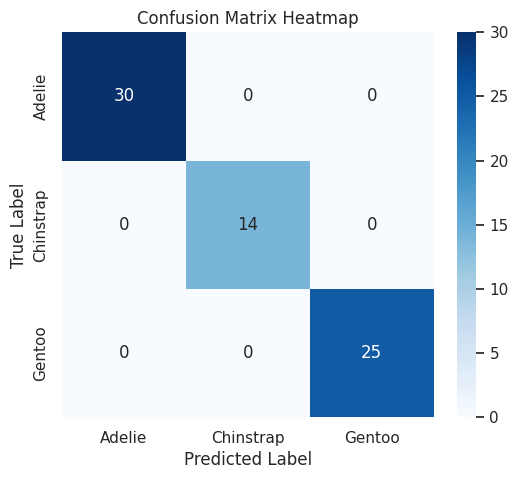

In [16]:
# Computing confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Ploting heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

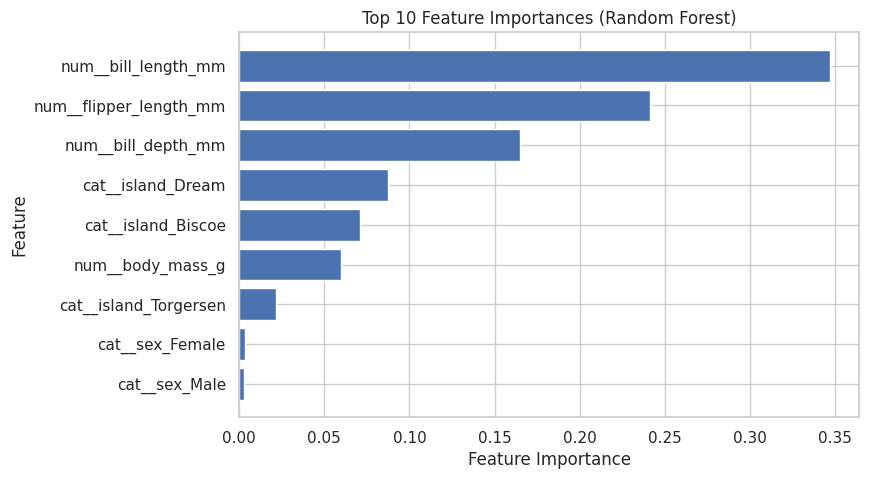

In [17]:
# Extracting feature names
feature_names = clf.named_steps['preprocessor'].get_feature_names_out()

# Extracting feature importances from Random Forest
importances = clf.named_steps['model'].feature_importances_

# Creating a clean importance table
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Selecting Top 10 features
top_10_features = feature_importance_df.head(10)
top_10_features

# Visualizing Top 10 feature importances
plt.figure(figsize=(8, 5))
plt.barh(
    top_10_features['feature'],
    top_10_features['importance']
)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

# **Random Forest - Final Insights & Project Conclusion**

---

## **Project Objective Recap**

The goal of this project was to build a **robust multiclass classification model** to predict penguin species (**Adelie, Chinstrap, Gentoo**) using physical measurements and contextual features from the Palmer Penguins dataset. The emphasis was not only on model accuracy, but also on correct methodology: proper EDA, leakage-free preprocessing, and interpretable evaluation.

**Key Insights from Exploratory Data Analysis:**

1. **Dataset Quality**
    - The dataset contains **344 observations** and **7 features**, with low missingness.
    - **Missing values** were **limited** and **non-systematic**, making imputation preferable to row deletion.
    - No invalid or biologically implausible values were observed.

2. **Target Distribution**
    - **Species classes** were **mildly imbalanced (Adelie > Gentoo > Chinstrap)**, but not severely.
    - Stratified splitting was sufficient; resampling techniques were unnecessary.

3. **Feature Behavior**
    - Numerical features (bill length, bill depth, flipper length, body mass) showed clear inter-species separation, especially for Gentoo.
    - Overlaps between Adelie and Chinstrap were expected biological variation, not noise.
    - The `sex` feature showed balanced distributions across species, indicating weak standalone predictive power but acceptable as a supporting feature.

---

## **Modeling and Preprocessing Decisions**

1. **Preprocessing Strategy**
    - Separate pipelines were used for numerical and categorical features due to fundamentally different statistical requirements.
    - Median imputation for numerical features ensured robustness to outliers.
    - Mode imputation followed by one-hot encoding handled categorical features safely.
    - All preprocessing was implemented inside a `Pipeline` and `ColumnTransformer`, ensuring:
      - **No data leakage**
      - **Correct train–test separation**
      - **Reproducibility and deployment readiness**

2. **Model Choice**
    - A **Random Forest classifier** was selected due to:
      - Strong performance on tabular data
      - Ability to model nonlinear relationships
      - Robustness to feature scaling and mild noise
    - A baseline configuration (200 trees, no tuning) was used to establish a reliable performance benchmark.

---

## **Model Performance and Evaluation**

1. **Overall Performance**
    - The model achieved very high accuracy on the test set.
    - Precision, recall, and F1-scores were consistently strong across all three species.

2. **Class-Level Behavior**
    - The confusion matrix showed:
      - Near-perfect classification for Gentoo
      - Minor, expected confusion between Adelie and Chinstrap
    - No evidence of majority-class dominance or minority-class neglect was observed.

3. **Feature Importance**
    - The most influential features were:
      - `flipper_length_mm`
      - `bill_length_mm`
      - `bill_depth_mm`
      - `body_mass_g`
    - Categorical features (`island`, `sex`) contributed marginally, acting as contextual signals rather than primary drivers.
    - Feature importance was interpreted as model behavior insight, not causal inference.

---

## **Final Conclusion**

This project demonstrates that the Penguins dataset is highly suitable for supervised multiclass classification when handled with proper preprocessing and evaluation discipline. The **Random Forest model**, combined with a **leakage-safe pipeline**, delivers **strong and stable performance without the need for aggressive tuning or complex feature engineering**.

More importantly, the project validates correct machine learning practice:

- EDA guided decisions instead of assumptions
- Preprocessing was learned only from training data
- Pipelines enforced consistency and prevented silent errors
- Evaluation focused on class-level performance, not just accuracy

If extended further, this work could incorporate:
- Hyperparameter tuning for marginal gains
- Permutation importance or SHAP for more reliable interpretability
- Cross-validation for performance stability estimates